# TransCanada Timeseries Forecasting Example
- The original use case was to forecast the natural gas volume through gas meters given the local weather (temp, wind chill, etc). The purpose was to estimate future gas demand so that the correct pressure could be set throughout the system. 
- The dataset in this example has been taken from the UCI Machine Learning Repository and it is concerned with predicting polution given the local weather (temp, wind chill, etc). 

First, we load libraries that we will need for the model training and deployment.

In [1]:
# Import important libraries
import pandas as pd
# import numpy as np
import boto3
# import io
# import re
import sagemaker as sage
# from time import gmtime, strftime
# import itertools
from math import sqrt
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from io import StringIO
# from io import BytesIO
from datetime import datetime

### Import the datset locally and load into the s3 bucket
We first load the data set into a Pandas DataFrame for feature selection and cleaning. We select those features that are relevant to this forecasting task by manually specifying column names, parse the time, and
- mark all NA values with 0
- drop the first 24 hours

We included optional code to save the data in a CSV file in the local notebook instance. Finally display the first 5 rows to inspect the data frame. 

In [2]:
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

dataset = pd.read_csv('AwsSecurityAudit_Meta31_DescribeDBInstances.csv'
                   , index_col=0)
#dataset.drop('No', axis=1, inplace=True)
#dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
#dataset['pollution'].fillna(0, inplace=True)
#dataset = dataset[24:]
# Unselect to save data to a file in the notebook instance:
# dataset.to_csv('pollution.csv')
dataset.head(5)

,arn,api,count
date,,,
2019-06-25,arn=arn:aws:sts::002726030336:assumed-role/Aw...,DescribeDBInstances,8
2019-06-26,arn=arn:aws:sts::002726030336:assumed-role/Aw...,DescribeDBInstances,4
2019-06-27,arn=arn:aws:sts::002726030336:assumed-role/Aw...,DescribeDBInstances,8
2019-06-28,arn=arn:aws:sts::002726030336:assumed-role/Aw...,DescribeDBInstances,4
2019-06-29,arn=arn:aws:sts::002726030336:assumed-role/Aw...,DescribeDBInstances,8


In [3]:
dataset = dataset[['count']]
dataset.head()

,count
date,
2019-06-25,8
2019-06-26,4
2019-06-27,8
2019-06-28,4
2019-06-29,8


To upload the data to S3, we define the name of the bucket and the prefix that will be used throughout the notebook. We then create an S3 resource client and upload the data to S3 directly from teh data frame object in memory. 

In [4]:
#Define the s3 bucket
region = boto3.Session().region_name
bucket ='zppeter-reinvent-2019'
prefix = 'data'

In [5]:
s3 = boto3.client("s3")
s3_resource = boto3.resource('s3')

csv_buffer = StringIO()
dataset.to_csv(csv_buffer)
s3_resource.Object(bucket, prefix+'/pollution.csv').put(Body=csv_buffer.getvalue())

{'ResponseMetadata': {'RequestId': '2F6273876DE93069',
  'HostId': 'OuCdRl1+m5UXVlWMls+B8ETCT8ee5mhX4kmKkzsi5yX4Fy00EPal3TMOAZvBnBRMpRc4hwRKYwo=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'OuCdRl1+m5UXVlWMls+B8ETCT8ee5mhX4kmKkzsi5yX4Fy00EPal3TMOAZvBnBRMpRc4hwRKYwo=',
   'x-amz-request-id': '2F6273876DE93069',
   'date': 'Wed, 20 Nov 2019 16:50:45 GMT',
   'etag': '"3550664946322763608e3146eba1923f"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"3550664946322763608e3146eba1923f"'}

### Visualize the Data
Plot the features in the dataset to observe seasonal patterns.

In [5]:
# load dataset
# dataset = pd.read_csv('s3://'+bucket+'/'+prefix+'/pollution.csv')
# dataset['date'] = pd.to_datetime(dataset['date'])
# dataset.set_index('date', inplace=True)
# dataset.head()

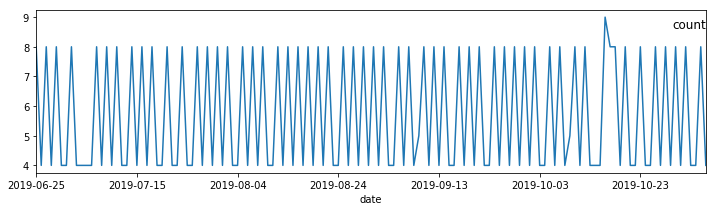

In [6]:
features_of_interest = ['count']
pyplot.figure(figsize=(12,3*len(features_of_interest)))
for i,f in enumerate(features_of_interest):
    if i==0: ax0 = pyplot.subplot(len(features_of_interest), 1, i+1)
    else: pyplot.subplot(len(features_of_interest), 1, i+1, sharex = ax0)
    dataset[f].plot()
    pyplot.title(f, y=0.85, loc='right')
pyplot.subplots_adjust(hspace=0.05)

### Prepare data for timeseries forecasting
We next define a function that will take timeseries data and create a data structure where input sequence `(t-n, ... t-1)` forecasts an output sequence `(t, t+1, ... t+n)`. This will provide training data for the forecasting algorithm.  

In [7]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    if dropnan:
        agg.dropna(inplace=True)  # drop rows with NaN values
    return agg

In [8]:
# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
    # extract raw values
    raw_values = series.values
    
    # integer encode direction
    encoder = LabelEncoder()
    raw_values[:,0] = encoder.fit_transform(raw_values[:,0])

    # rescale values to -1, 1
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_values = scaler.fit_transform(raw_values)
    scaled_values = scaled_values.reshape(len(scaled_values), 1)
    
    # transform into supervised learning problem X, y
    supervised = series_to_supervised(scaled_values, n_lag, n_seq)
    supervised = supervised[['var1(t-1)',
                             'var1(t)']]
    supervised_values = supervised.values
    # split into train and test sets
    train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
    return scaler, train, test

In [9]:
series = dataset

# configure
n_lag = 1
n_seq = 1
n_test = 30

# prepare data
scaler, train, test = prepare_data(series, n_test, n_lag, n_seq)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [10]:
print(train.shape)

(103, 2)


### Split data into training and testing sets and save in s3

In [11]:
df_train = pd.DataFrame(train)
df_train.head()

,0,1
0,0.666667,0.000000
1,0.000000,0.666667
2,0.666667,0.000000
3,0.000000,0.666667
4,0.666667,0.000000


In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 2 columns):
0    103 non-null float64
1    103 non-null float64
dtypes: float64(2)
memory usage: 1.7 KB


In [13]:
# select the first 30000 observations and save training set in s3:

csv_buffer = StringIO()
df_train[:70].to_csv(csv_buffer,index=False)
s3_resource.Object(bucket, prefix+'/train/train.csv').put(Body=csv_buffer.getvalue())

{'ResponseMetadata': {'RequestId': 'D265688526724F34',
  'HostId': 'yaOUI/LwYV5bQvAId2W6tH82zLdLAKnLg9ktkMILVsvQnU57D74uMwg435CRVvIUVQkzsmdBjdc=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'yaOUI/LwYV5bQvAId2W6tH82zLdLAKnLg9ktkMILVsvQnU57D74uMwg435CRVvIUVQkzsmdBjdc=',
   'x-amz-request-id': 'D265688526724F34',
   'date': 'Wed, 20 Nov 2019 16:51:13 GMT',
   'etag': '"a0b9c9fa336ae6c85ce8f4da8f381234"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"a0b9c9fa336ae6c85ce8f4da8f381234"'}

In [14]:
# save validation set in s3

csv_buffer = StringIO()
df_train[70:].to_csv(csv_buffer,index=False)
s3_resource.Object(bucket, prefix+'/validation/val.csv').put(Body=csv_buffer.getvalue())

{'ResponseMetadata': {'RequestId': '7EB86D82C367BD49',
  'HostId': 'blsLCXYL7wDHxoGnrpew7HINoEhMjV+b/7GTCqZ/TlPWktIamynS1Xo1JHs1Dcp2h4tTppSu0tk=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'blsLCXYL7wDHxoGnrpew7HINoEhMjV+b/7GTCqZ/TlPWktIamynS1Xo1JHs1Dcp2h4tTppSu0tk=',
   'x-amz-request-id': '7EB86D82C367BD49',
   'date': 'Wed, 20 Nov 2019 16:51:18 GMT',
   'etag': '"979f390392a826524df6abdcd1fa179d"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"979f390392a826524df6abdcd1fa179d"'}

### Build the docker image and push it to ECS
Create folders named `train` and `serve` in `s3://transcanada-poc/data/train`.

In [15]:
%%sh
# The name of our algorithm
algorithm_name=zppeter-reinvent2019


chmod +x train/train
chmod +x train/serve

# Get the account and region defined in the current configuration (default to us-west-2 if none defined)
account=$(aws sts get-caller-identity --query Account --output text)
region=$(aws configure get region)
region=${region:-us-east-1}
fullname="${account}.dkr.ecr.${region}.amazonaws.com/${algorithm_name}:latest"

# If the repository doesn't exist in ECR, create it.
aws ecr describe-repositories --repository-names "${algorithm_name}" > /dev/null 2>&1
if [ $? -ne 0 ]
then
    aws ecr create-repository --repository-name "${algorithm_name}" > /dev/null
fi

# Get the login command from ECR and execute it directly
$(aws ecr get-login --region ${region} --no-include-email)

# Build the docker image locally with the image name and then push it to ECR
# with the full name.
docker build  -t ${algorithm_name} .
docker tag ${algorithm_name} ${fullname}
docker push ${fullname}

Login Succeeded

Step 1/9 : FROM nvidia/cuda:9.2-runtime
 ---> 31591a654242
Step 2/9 : MAINTAINER Amazon AI <sage-learner@amazon.com>
 ---> Using cache
 ---> de67120bb806
Step 3/9 : RUN apt-get -y update && apt-get install -y --no-install-recommends          wget          python          nginx          ca-certificates     && rm -rf /var/lib/apt/lists/*
 ---> Using cache
 ---> a696f287d871
Step 4/9 : RUN wget https://bootstrap.pypa.io/get-pip.py && python get-pip.py &&     pip install numpy==1.16.2 scipy==1.2.1 scikit-learn==0.20.2 keras==2.2.4 tensorflow==1.13.1 pandas==0.24 flask==1.0.2 gevent==1.4.0 gunicorn==19.9.0 &&         (cd /usr/local/lib/python2.7/dist-packages/scipy/.libs; rm *; ln ../../numpy/.libs/* .) &&         rm -rf /root/.cache
 ---> Using cache
 ---> 653698076698
Step 5/9 : ENV PYTHONUNBUFFERED=TRUE
 ---> Using cache
 ---> b5298c92f852
Step 6/9 : ENV PYTHONDONTWRITEBYTECODE=TRUE
 ---> Using cache
 ---> 67a1271675dd
Step 7/9 : ENV PATH="/opt/program:${PATH}"
 ---> Usi

WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store



In [16]:
train = pd.read_csv('s3://'+bucket+'/'+prefix+'/train/train.csv')
train.head()

,0,1
0,0.666667,0.000000
1,0.000000,0.666667
2,0.666667,0.000000
3,0.000000,0.666667
4,0.666667,0.000000


### Train the model and set up the endpoint for inference.

In [17]:
role = sage.get_execution_role()
sess = sage.Session()
source_bucket_uri = 's3://'+bucket+'/'+prefix+'/train/'

# Get account and region to create the image 
account = sess.boto_session.client('sts').get_caller_identity()['Account']
region = sess.boto_session.region_name
image = '{}.dkr.ecr.{}.amazonaws.com/{}:latest'.format(account, region, 'zppeter-reinvent2019')

In [18]:
image

'532109487980.dkr.ecr.us-east-1.amazonaws.com/zppeter-reinvent2019:latest'

In [19]:
# Set up SageMaker Estimator and fit the training job
model = sage.estimator.Estimator(image,
                      role, 1, 'ml.p3.8xlarge',
#                       role, 1, 'ml.p3.2xlarge',
                      output_path="s3://{}/output".format(sess.default_bucket()),
                      sagemaker_session=sess)
model.fit(source_bucket_uri)

2019-11-20 16:53:37 Starting - Starting the training job......................................................................................................................................................
2019-11-20 17:18:39 Starting - Launching requested ML instances......
2019-11-20 17:19:43 Starting - Preparing the instances for training......
2019-11-20 17:20:47 Downloading - Downloading input data
2019-11-20 17:20:47 Training - Downloading the training image......
2019-11-20 17:21:32 Training - Training image download completed. Training in progress.Using TensorFlow backend.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
2019-11-20 17:21:35.521048: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2019-11-20 17:21:35.558389: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300040000 Hz
20

In [20]:
# Create the model endpoint 
predictor = model.deploy(1, 'ml.t2.medium', serializer=sage.predictor.csv_serializer)

---------------------------------------------------------------------------------------------------------------------------!

### Test that the endpoint is working

In [21]:
test_X = pd.DataFrame(test)

In [22]:
test_X.head(10)

,0,1
0,0.000000,0.666667
1,0.666667,0.000000
2,0.000000,0.333333
3,0.333333,0.666667
4,0.666667,0.000000
5,0.000000,0.666667
6,0.666667,0.000000
7,0.000000,0.000000
8,0.000000,0.000000
9,0.000000,1.000000


In [23]:
test_X=test_X.iloc[:,:1]
test_X.head()

,0
0,0.000000
1,0.666667
2,0.000000
3,0.333333
4,0.666667


In [24]:
print(predictor.predict(test_X.values).decode('utf-8'))

0.48611867
0.001436606
0.48611867
0.22559805
0.001436606
0.48611867
0.001436606
0.48611867
0.48611867
0.48611867
-0.16348293
0.001436606
0.001436606
0.48611867
0.001436606
0.48611867
0.48611867
0.001436606
0.48611867
0.48611867
0.001436606
0.48611867
0.001436606
0.48611867
0.001436606
0.48611867
0.001436606
0.48611867
0.48611867
0.001436606



In [25]:
sess = sage.Session()

In [30]:
#predictor = sage.predictor.RealTimePredictor('transcanada-poc-2019-03-14-22-08-36-490',serializer=csv_serializer)

NameError: name 'csv_serializer' is not defined

In [26]:
predictions = predictor.predict(test_X.values).decode('utf-8').split('\n')

In [27]:
type(predictions[1])

str

In [28]:
n_features = 1
actual = [row[n_features:] for row in test]

In [29]:
forecasts = list()
for i in range(len(test)):
    # make forecast
    forecast = [float(s) for s in predictions[i].split(',')]
    # store the forecast
    forecasts.append(forecast)

In [30]:
# evaluate the RMSE for each forecast time step
from sklearn.metrics import mean_squared_error

def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        print('t+%d RMSE: %f' % ((i+1), rmse))
        
evaluate_forecasts(actual, forecasts, n_lag, n_seq)

t+1 RMSE: 0.320863


In [32]:
#transform back to the original scale
raw_values = series.values

# transform into supervised learning problem X, y
supervised = series_to_supervised(raw_values, n_lag, n_seq)
supervised = supervised[['var1(t)']]
supervised_values = supervised.values

# rescale values to -1, 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(supervised_values)
scaled_values = scaled_values.reshape(len(scaled_values), 1)

inv_forecast = scaler.inverse_transform(forecasts)
inv_actual = scaler.inverse_transform(actual)

evaluate_forecasts(inv_actual, inv_forecast, n_lag, n_seq)

t+1 RMSE: 0.962590


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [33]:
# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
    # plot the entire dataset in blue
    pyplot.figure(figsize=(20,5))
    pyplot.plot(series.values)
    # plot the forecasts in red
    for i in range(len(forecasts)):
        off_s = len(series) - n_test + i -1
        off_e = off_s + len(forecasts[i]) +1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [series.values[off_s]] + list(forecasts[i]) 
        pyplot.plot(xaxis, yaxis, color='red')
    # show the plot
    pyplot.show()

In [38]:
polution = dataset['count'][-32:]

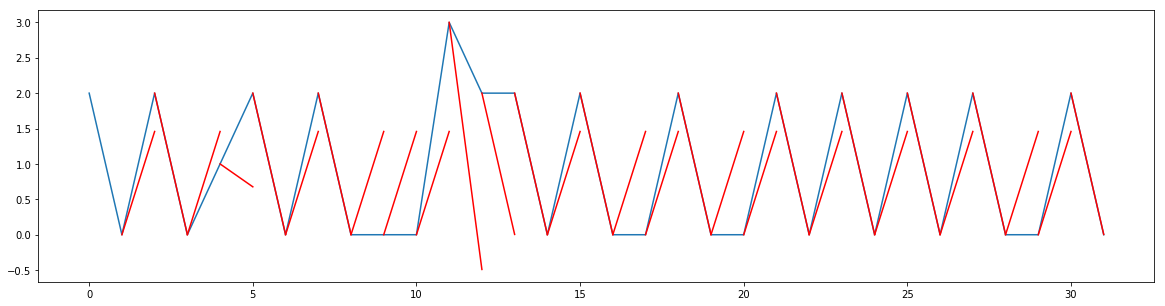

In [46]:
plot_forecasts(polution, inv_forecast, 30)

In [ ]:
# delete endpoint so you avoid any recuring charges
sess.delete_endpoint(predictor.endpoint)